In [1]:
from Losses.AdversarialLoss import calc_Dw_loss
from Models.Encoders.ID_Encoder import resnet50_scratch_dag
from Models.Encoders.Attribute_Encoder import Encoder_Attribute
from Models.Discrimanator import Discriminator
from Models.MLP import MLPModel
import torch
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()


In [2]:
def get_data(mean, std, image_size, data_dir):
    full_dataset = dset.ImageFolder(root=data_dir,
                                    transform=transforms.Compose([
                                        transforms.Resize(image_size),
                                        transforms.ToTensor(),
                                    ]))

    return full_dataset


In [3]:
def make_loaders(dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size)

    return train_loader

In [4]:
####### Create Models #######
id_encoder = resnet50_scratch_dag(weights_path=r'..\Weights\resnet50_scratch_dag.pth')

# The model should be kept frozen during training time
id_encoder.eval()

attr_encoder = Encoder_Attribute()
discriminator = Discriminator(512, 512)
mlp = MLPModel(4096, n_hid=2048)

Using cache found in C:\Users\danie/.cache\torch\hub\pytorch_vision_v0.6.0
c:\users\danie\desktop\python envs\pytorch\lib\site-packages\torchvision\models\inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [5]:
####### Create data #######
data_folder = get_data(id_encoder.meta['mean'], id_encoder.meta['std'], id_encoder.meta['imageSize'][1],
                       r'..\Datasets\fake_256\images')
train_loader = make_loaders(data_folder, 8)
images, _ = next(iter(train_loader))

In [6]:
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.99, 0.999))
optimizerMLP = torch.optim.Adam(mlp.parameters(), lr=0.01, betas=(0.99, 0.999))

In [7]:
####### Forward Pass #######
_, id_vec = id_encoder(images)
#_, attr_vec = attr_encoder(images)
id_vec = torch.squeeze(id_vec)
attr_vec = torch.squeeze(id_vec)
encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
generated_w_vec = mlp(encoded_vec)

C:\Users\danie\Desktop\CS_year3\CNN Project\Face-Identity-Disentanglement-via-StyleGan2\Models\Encoders\ID_Encoder.py:206: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)


In [8]:
MLP_losses = []
D_losses = []

In [9]:
####### Discriminator back pass #######



discriminator.zero_grad()
for epoch in range(50):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    discriminator.zero_grad()

    real_w = np.load(r'..\Datasets\fake_256\ws\00000\00001.npy')
    real_w = real_w[:8]
    real_prob = discriminator(torch.from_numpy(real_w)).view(-1)
    errD_real = calc_Dw_loss(real_prob, 0, "cpu", generated_w_vec, 0.01)
    errD_real.backward()
    D_x = real_prob.mean().item()
    print(f'D real loss is: {D_x}')

    fake_prob = discriminator(generated_w_vec.detach()).view(-1)
    errD_fake = calc_Dw_loss(fake_prob, 0, "cpu", generated_w_vec, 0.01)
    errD_fake.backward()
    D_G_z1  = fake_prob.mean().item()
    print(f'D fake loss is: {D_G_z1}')

    errD = errD_fake + errD_real
    optimizerD.step()
    
    
    ############################
    # (2) Update MLP network: maximize log(D(G(z)))
    ###########################
    mlp.zero_grad()
    # Since we just updated D, perform another forward pass of all-fake batch through D
    fake_prob = discriminator(generated_w_vec.detach()).view(-1)
    errMLP = calc_Dw_loss(fake_prob, 0, "cpu", generated_w_vec, 0.01)
    # Calculate gradients for MLP
    errMLP.backward()
    D_MLP = fake_prob.mean().item()

    # Update G
    optimizerMLP.step()


    MLP_losses.append(errMLP.item())
    D_losses.append(errD.item())


D real loss is: 0.47813960909843445
D fake loss is: 0.4767376482486725
D real loss is: 0.4740336835384369
D fake loss is: 0.4457499384880066
D real loss is: 0.48591235280036926
D fake loss is: 0.47072386741638184
D real loss is: 0.46232327818870544
D fake loss is: 0.3907124102115631
D real loss is: 0.4169256091117859
D fake loss is: 0.4047323763370514
D real loss is: 0.39574292302131653
D fake loss is: 0.37314730882644653
D real loss is: 0.43006372451782227
D fake loss is: 0.4418800473213196
D real loss is: 0.41177505254745483
D fake loss is: 0.3976772725582123
D real loss is: 0.41464388370513916
D fake loss is: 0.39958953857421875
D real loss is: 0.3629720211029053
D fake loss is: 0.38130706548690796
D real loss is: 0.38625234365463257
D fake loss is: 0.3597509562969208
D real loss is: 0.37849369645118713
D fake loss is: 0.35680609941482544
D real loss is: 0.3706633746623993
D fake loss is: 0.25499415397644043
D real loss is: 0.3210521936416626
D fake loss is: 0.29951274394989014
D re

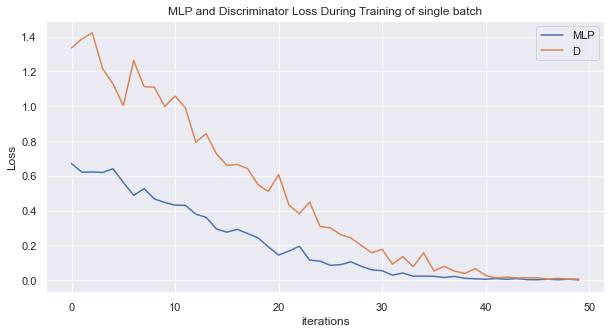

In [10]:
plt.figure(figsize=(10,5))
plt.title("MLP and Discriminator Loss During Training of single batch")
plt.plot(MLP_losses,label="MLP")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
image = images[0].cpu().detach().numpy().transpose(1,2,0)


(0.0, 1.0, 0.0, 1.0)

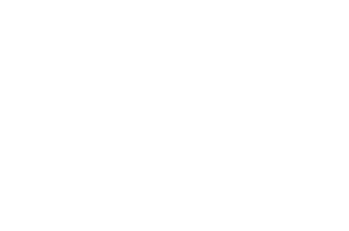

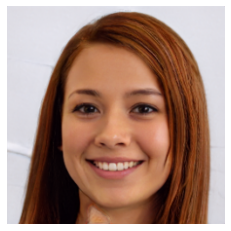

In [21]:
plt.axis('off')
plt.imshow(image)
plt.show()


In [22]:
_, id_vec = id_encoder(images)
#_, attr_vec = attr_encoder(images)
id_vec = torch.squeeze(id_vec)
attr_vec = torch.squeeze(id_vec)
encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
generated_w_vec = mlp(encoded_vec)



In [26]:
np.save('result',generated_w_vec[0].detach().numpy())
